In [100]:
from __future__ import unicode_literals, print_function, division
import torch
import torch.nn as nn

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../preprocessing/') #need this in order to get to the other file in other directory

#can comment out the ones you aren't using to save a little bit of time
from covidPreprocess import getCoronaVocabulary, getCoronaText
from liarPreprocess import getLiarVocabulary, getLiarText
from fnnPreprocess import getFNNVocabulary, getFNNText
# from fnnCovidCombinedPreprocess import getFNNCoronaVocabulary, getFNNCoronaText

In [101]:
class SimpleNeuralNet(nn.Module):
    # Simple Feed Forward Neural Network with One Hidden Layer that Outputs One Neuron (Binary Classification, can't handle more than 2 classes)
    
    def __init__(self, input_size, hidden_size):
        super(SimpleNeuralNet, self).__init__()
        #Written based off of the tutorial at
        #https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/01-basics/feedforward_neural_network/main.py#L37-L49
        self.hidden1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()   
        self.oupt = nn.Linear(hidden_size, 1)  

    def forward(self, x):
        out = torch.tanh(self.hidden1(x))
        out = torch.sigmoid(self.oupt(out))
        return out

In [102]:
def trainAndTestSimpleModel(dataset: str, num_epochs = 5, learning_rate = 0.001, print_epoch_mod = 5):
    '''
    Used this article for help in writing the tensor parts of code so it works with the model
    https://medium.com/analytics-vidhya/part-1-sentiment-analysis-in-pytorch-82b35edb40b8
    
    Train and tests, calculates both training and test accuracy, models that use SimpleNeuralNet.
    '''
    torch.manual_seed(1)
    if dataset == 'corona':
        X,Y = getCoronaText() #this function will give us the text array (not document term matrix) and Y
        X_train,Y_train, vectorizer_train = getCoronaVocabulary(True)
    elif dataset == 'liar':
        X,Y = getLiarText()
        X_train,Y_train, vectorizer_train = getLiarVocabulary(True)
    elif dataset == 'fnn':
        X,Y = getFNNText()
        X_train,Y_train, vectorizer_train = getFNNVocabulary(True)
    
    #transform our testing dataset to match the vocabulary for the training dataset
    #transform will return the document-term matrix for X based on training dataset
    x_test = vectorizer_train.transform(X)
    
    vocabsize = X_train.shape[1]
    
    
    #transform our training and test data into tensors for the classifier to learn off of
    X_tensor = torch.from_numpy(X_train.todense()).float()
    Y_tensor = torch.from_numpy(np.array(Y_train)).float()
    
    X_test_tensor = torch.from_numpy(x_test.todense()).float()
    Y_test_tensor = torch.from_numpy(np.array(Y))
    
    device = torch.device('cpu')
    #use TensorDataset to be able to use our DataLoader
    train_data = torch.utils.data.TensorDataset(X_tensor, Y_tensor)
    train_loader = torch.utils.data.DataLoader(train_data,batch_size=16, shuffle=False)
    train_loader_batch_size_1 = torch.utils.data.DataLoader(train_data,batch_size=1, shuffle=False)
    
    test_data = torch.utils.data.TensorDataset(X_test_tensor, Y_test_tensor)
    test_loader = torch.utils.data.DataLoader(test_data,batch_size=1, shuffle=False)
    
    #initialize our model
    model = SimpleNeuralNet(vocabsize, 200).to(device)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    
    
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (x_batch, labels) in enumerate(train_loader):
    
            # Forward pass
            # The forward process computes the loss of each iteration on each sample
            model.train()
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, labels.reshape(-1, 1))
    
            # Backward pass, using the optimizer to update the parameters
            optimizer.zero_grad()
            loss.backward()    #compute gradients
            optimizer.step()   #initiate gradient descent
    
     
            # Below, an epoch corresponds to one pass through all of the samples.
            # Each training step corresponds to a parameter update using 
            # a gradient computed on a minibatch of 100 samples 
            if (i + 1) % print_epoch_mod == 0: 
                #leaving it on 5 for corona dataset, probably want to change to % 50 or % 100
                # for the other datasets so don't get spammed 
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
    
    # Test the model
    # In the test phase, we don't need to compute gradients (the model has already been learned)
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, label in test_loader:
            output = model(inputs)
            total += 1
            if label >= 0.5 and output >= 0.5:
                correct += 1
            elif label < 0.5 and output < 0.5:
                correct += 1
            
        print('Test accuracy of the network: {} %'.format(100 * correct / total))
        test_accuracy = 100 * correct / total
        
    # Print out training accuracy
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, label in train_loader_batch_size_1:
            output = model(inputs)
            total += 1
            if label >= 0.5 and output >= 0.5:
                correct += 1
            elif label < 0.5 and output < 0.5:
                correct += 1
                
        print('Train accuracy of the network: {} %'.format(100 * correct / total))
        train_accuracy = 100 * correct / total
    
    return test_accuracy, train_accuracy

In [86]:
import pickle

In [88]:
test_accuracy, train_accuracy, model, vectorizer_train = trainAndTestSimpleModel('corona', num_epochs=50)
torch.save(model, 'covid_saved_model')
pickle.dump(vectorizer_train, open('covid_vec.pkl', 'wb'))

Epoch [1/50], Step [5/19], Loss: 0.3543
Epoch [1/50], Step [10/19], Loss: 0.5111
Epoch [1/50], Step [15/19], Loss: 0.2169
Epoch [2/50], Step [5/19], Loss: 0.0395
Epoch [2/50], Step [10/19], Loss: 0.1832
Epoch [2/50], Step [15/19], Loss: 0.0935
Epoch [3/50], Step [5/19], Loss: 0.0094
Epoch [3/50], Step [10/19], Loss: 0.0684
Epoch [3/50], Step [15/19], Loss: 0.0311
Epoch [4/50], Step [5/19], Loss: 0.0038
Epoch [4/50], Step [10/19], Loss: 0.0362
Epoch [4/50], Step [15/19], Loss: 0.0157
Epoch [5/50], Step [5/19], Loss: 0.0021
Epoch [5/50], Step [10/19], Loss: 0.0217
Epoch [5/50], Step [15/19], Loss: 0.0092
Epoch [6/50], Step [5/19], Loss: 0.0013
Epoch [6/50], Step [10/19], Loss: 0.0140
Epoch [6/50], Step [15/19], Loss: 0.0059
Epoch [7/50], Step [5/19], Loss: 0.0009
Epoch [7/50], Step [10/19], Loss: 0.0097
Epoch [7/50], Step [15/19], Loss: 0.0041
Epoch [8/50], Step [5/19], Loss: 0.0007
Epoch [8/50], Step [10/19], Loss: 0.0071
Epoch [8/50], Step [15/19], Loss: 0.0030
Epoch [9/50], Step [5/19

In [103]:
num_epochs_used = [1, 5, 10, 20, 30, 40, 50, 60, 75, 100]
corona_test_accuracies = []
corona_train_accuracies = []

In [104]:
for num_epoch in num_epochs_used:
    test_accuracy, train_accuracy = trainAndTestSimpleModel('corona', num_epochs=num_epoch)
    corona_test_accuracies.append(test_accuracy)
    corona_train_accuracies.append(train_accuracy)

Epoch [1/1], Step [5/19], Loss: 0.3543
Epoch [1/1], Step [10/19], Loss: 0.5111
Epoch [1/1], Step [15/19], Loss: 0.2169
Test accuracy of the network: 86.71248568155785 %
Train accuracy of the network: 97.2508591065292 %
Epoch [1/5], Step [5/19], Loss: 0.3543
Epoch [1/5], Step [10/19], Loss: 0.5111
Epoch [1/5], Step [15/19], Loss: 0.2169
Epoch [2/5], Step [5/19], Loss: 0.0395
Epoch [2/5], Step [10/19], Loss: 0.1832
Epoch [2/5], Step [15/19], Loss: 0.0935
Epoch [3/5], Step [5/19], Loss: 0.0094
Epoch [3/5], Step [10/19], Loss: 0.0684
Epoch [3/5], Step [15/19], Loss: 0.0311
Epoch [4/5], Step [5/19], Loss: 0.0038
Epoch [4/5], Step [10/19], Loss: 0.0362
Epoch [4/5], Step [15/19], Loss: 0.0157
Epoch [5/5], Step [5/19], Loss: 0.0021
Epoch [5/5], Step [10/19], Loss: 0.0217
Epoch [5/5], Step [15/19], Loss: 0.0092
Test accuracy of the network: 88.77434135166094 %
Train accuracy of the network: 100.0 %
Epoch [1/10], Step [5/19], Loss: 0.3543
Epoch [1/10], Step [10/19], Loss: 0.5111
Epoch [1/10], St

In [106]:
print(corona_train_accuracies)

[97.2508591065292, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


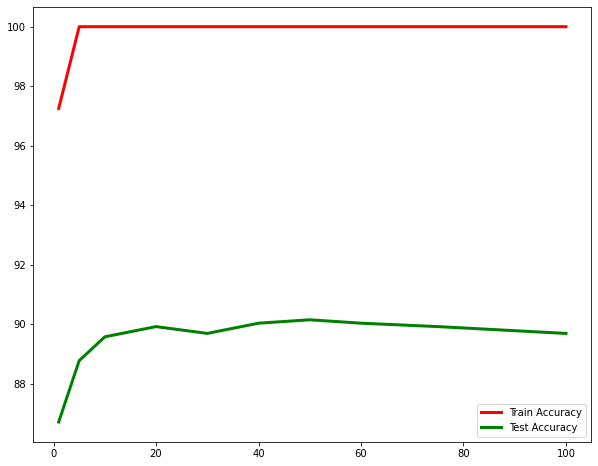

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(num_epochs_used, corona_train_accuracies, 'r-', lw=3, label='Train Accuracy')
ax.plot(num_epochs_used, corona_test_accuracies, 'g-', lw=3, label='Test Accuracy')
ax.legend()

plt.show()

In [99]:
print(len(num_epochs_used))
print(len(corona_train_accuracies))
print(len(corona_test_accuracies))

10
30
30


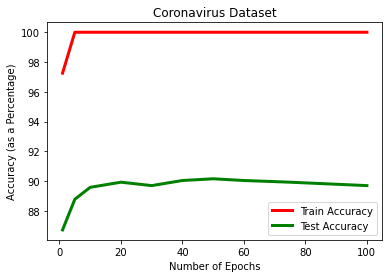

In [109]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plt.plot(num_epochs_used, corona_train_accuracies, 'r-', lw=3, label='Train Accuracy')
plt.plot(num_epochs_used, corona_test_accuracies, 'g-', lw=3, label='Test Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy (as a Percentage)')
plt.title('Coronavirus Dataset')
plt.legend()

plt.show()

In [70]:
liar_test_accuracies = []
liar_train_accuracies = []

for num_epoch in num_epochs_used:
    test_accuracy, train_accuracy = trainAndTestSimpleModel('liar', num_epochs=num_epoch, print_epoch_mod=500)
    liar_test_accuracies.append(test_accuracy)
    liar_train_accuracies.append(train_accuracy)


Extracting tokens....

Extracting tokens....
Data shape for text:  (15052, 4893)
Epoch [1/1], Step [500/941], Loss: 0.4891
Test accuracy of the network: 70.06319115323855 %
Train accuracy of the network: 81.27159181504119 %

Extracting tokens....

Extracting tokens....
Data shape for text:  (15052, 4893)
Epoch [1/5], Step [500/941], Loss: 0.4891
Epoch [2/5], Step [500/941], Loss: 0.4241
Epoch [3/5], Step [500/941], Loss: 0.3268
Epoch [4/5], Step [500/941], Loss: 0.1347
Epoch [5/5], Step [500/941], Loss: 0.0551
Test accuracy of the network: 67.9304897314376 %
Train accuracy of the network: 94.7315971299495 %

Extracting tokens....

Extracting tokens....
Data shape for text:  (15052, 4893)
Epoch [1/10], Step [500/941], Loss: 0.4891
Epoch [2/10], Step [500/941], Loss: 0.4241
Epoch [3/10], Step [500/941], Loss: 0.3268
Epoch [4/10], Step [500/941], Loss: 0.1347
Epoch [5/10], Step [500/941], Loss: 0.0551
Epoch [6/10], Step [500/941], Loss: 0.0201
Epoch [7/10], Step [500/941], Loss: 0.0199
E

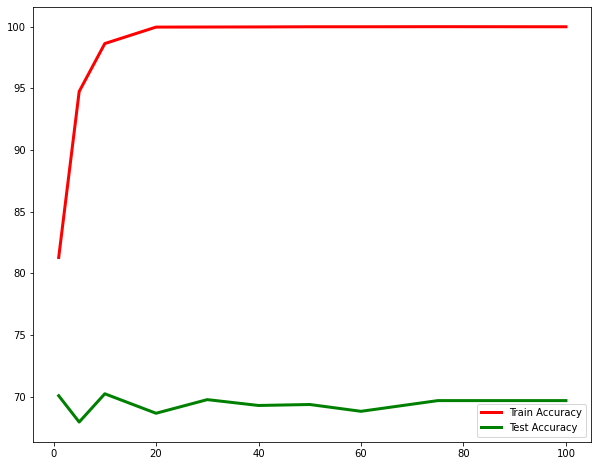

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(num_epochs_used, liar_train_accuracies, 'r-', lw=3, label='Train Accuracy')
ax.plot(num_epochs_used, liar_test_accuracies, 'g-', lw=3, label='Test Accuracy')
ax.legend()

plt.show()

ValueError: x and y must have same first dimension, but have shapes (10,) and (20,)

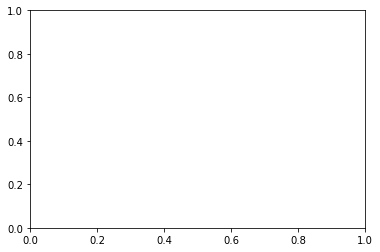

In [111]:
plt.plot(num_epochs_used, liar_train_accuracies, 'r-', lw=3, label='Train Accuracy')
plt.plot(num_epochs_used, liar_test_accuracies, 'g-', lw=3, label='Test Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy (as a Percentage)')
plt.title('Liar Dataset')
plt.legend()

plt.show()

In [93]:
fnn_test_accuracies = []
fnn_train_accuracies = []

for num_epoch in num_epochs_used:
    test_accuracy, train_accuracy = trainAndTestSimpleModel('fnn', num_epochs=num_epoch, print_epoch_mod=500)
    fnn_test_accuracies.append(test_accuracy)
    fnn_train_accuracies.append(train_accuracy)


Extracting tokens....

Extracting tokens....
Data shape for text:  (15212, 4975)
Epoch [1/1], Step [500/951], Loss: 0.6513
Test accuracy of the network: 80.74003795066413 %
Train accuracy of the network: 77.62950302392848 %

Extracting tokens....

Extracting tokens....
Data shape for text:  (15212, 4975)
Epoch [1/5], Step [500/951], Loss: 0.6513
Epoch [2/5], Step [500/951], Loss: 0.5977
Epoch [3/5], Step [500/951], Loss: 0.3836
Epoch [4/5], Step [500/951], Loss: 0.2220
Epoch [5/5], Step [500/951], Loss: 0.0589
Test accuracy of the network: 79.88614800759014 %
Train accuracy of the network: 92.93978438075204 %

Extracting tokens....

Extracting tokens....
Data shape for text:  (15212, 4975)
Epoch [1/10], Step [500/951], Loss: 0.6513
Epoch [2/10], Step [500/951], Loss: 0.5977
Epoch [3/10], Step [500/951], Loss: 0.3836
Epoch [4/10], Step [500/951], Loss: 0.2220
Epoch [5/10], Step [500/951], Loss: 0.0589
Epoch [6/10], Step [500/951], Loss: 0.0261
Epoch [7/10], Step [500/951], Loss: 0.0139

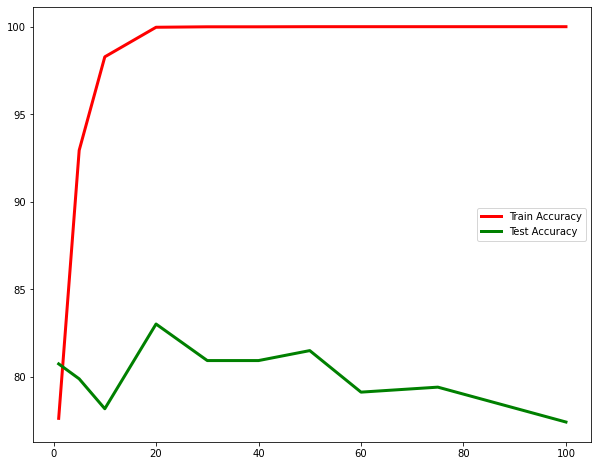

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(num_epochs_used, fnn_train_accuracies, 'r-', lw=3, label='Train Accuracy')
ax.plot(num_epochs_used, fnn_test_accuracies, 'g-', lw=3, label='Test Accuracy')
ax.legend()

plt.show()

In [73]:
class TwoHiddenLayerNeuralNet(nn.Module):
    # Feed Forward Neural Network with Two Hidden Layers that Outputs One Neuron (Binary Classification, can't handle more than 2 classes)

    def __init__(self, input_size, hidden_size):
        super(TwoHiddenLayerNeuralNet, self).__init__()
        #Written based off of the tutorial at
        #https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/01-basics/feedforward_neural_network/main.py#L37-L49
        self.hidden1 = nn.Linear(input_size, hidden_size) 
        self.hidden2 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()   
        self.oupt = nn.Linear(hidden_size, 1)   

    def forward(self, x):
        out = torch.tanh(self.hidden1(x))
        out = torch.tanh(self.hidden2(out))
        out = torch.sigmoid(self.oupt(out))
        return out

In [90]:
def trainAndTestTwoHiddenLayerModel(dataset: str, num_epochs = 5, learning_rate = 0.001, print_epoch_mod = 5):
    '''    
    used this article for help in writing the tensor parts of code so it works with the model
    https://medium.com/analytics-vidhya/part-1-sentiment-analysis-in-pytorch-82b35edb40b8
    
    Train and tests, calculates both training and test accuracy, models that use TwoHiddenLayerNeuralNet.
    '''
    torch.manual_seed(1)
    if dataset == 'corona':
        X,Y = getCoronaText() #this function will give us the text array (not document term matrix) and Y
        X_train,Y_train, vectorizer_train = getCoronaVocabulary(True)
    elif dataset == 'liar':
        X,Y = getLiarText()
        X_train,Y_train, vectorizer_train = getLiarVocabulary(True)
    elif dataset == 'fnn':
        X,Y = getFNNText()
        X_train,Y_train, vectorizer_train = getFNNVocabulary(True)
    
    #transform our testing dataset to match the vocabulary for the training dataset
    #transform will return the document-term matrix for X based on training dataset
    x_test = vectorizer_train.transform(X)

    vocabsize = X_train.shape[1]
    
    
    #transform our training and test data into tensors for the classifier to learn off of
    X_tensor = torch.from_numpy(X_train.todense()).float()
    Y_tensor = torch.from_numpy(np.array(Y_train)).float()
    
    X_test_tensor = torch.from_numpy(x_test.todense()).float()
    Y_test_tensor = torch.from_numpy(np.array(Y))
    
    device = torch.device('cpu')
    #use TensorDataset to be able to use our DataLoader
    train_data = torch.utils.data.TensorDataset(X_tensor, Y_tensor)
    train_loader = torch.utils.data.DataLoader(train_data,batch_size=16, shuffle=False)
    train_loader_batch_size_1 = torch.utils.data.DataLoader(train_data,batch_size=1, shuffle=False)
    
    test_data = torch.utils.data.TensorDataset(X_test_tensor, Y_test_tensor)
    test_loader = torch.utils.data.DataLoader(test_data,batch_size=1, shuffle=False)
    
    #initialize our model
    model = TwoHiddenLayerNeuralNet(vocabsize, 200).to(device)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    
    
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (x_batch, labels) in enumerate(train_loader):
    
            # Forward pass
            # The forward process computes the loss of each iteration on each sample
            model.train()
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, labels.reshape(-1, 1))
    
            # Backward pass, using the optimizer to update the parameters
            optimizer.zero_grad()
            loss.backward()    #compute gradients
            optimizer.step()   #initiate gradient descent
    
     
            # Below, an epoch corresponds to one pass through all of the samples.
            # Each training step corresponds to a parameter update using 
            # a gradient computed on a minibatch of 100 samples 
            if (i + 1) % print_epoch_mod == 0: 
                #leaving it on 5 for corona dataset, probably want to change to % 50 or % 100
                # for the other datasets so don't get spammed 
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
    
    # Test the model
    # In the test phase, we don't need to compute gradients (the model has already been learned)
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, label in test_loader:
            output = model(inputs)
            total += 1
            if label >= 0.5 and output >= 0.5:
                correct += 1
            elif label < 0.5 and output < 0.5:
                correct += 1
            
        print('Test accuracy of the network: {} %'.format(100 * correct / total))
        test_accuracy = 100 * correct / total
        
    # Print out training accuracy
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, label in train_loader_batch_size_1:
            output = model(inputs)
            total += 1
            if label >= 0.5 and output >= 0.5:
                correct += 1
            elif label < 0.5 and output < 0.5:
                correct += 1
                
        print('Train accuracy of the network: {} %'.format(100 * correct / total))
        train_accuracy = 100 * correct / total
    
    return test_accuracy, train_accuracy, model, vectorizer_train

In [91]:
test_accuracy, train_accuracy, model, vectorizer_train = trainAndTestTwoHiddenLayerModel('fnn', num_epochs=5)
torch.save(model, 'fnn_saved_model')
pickle.dump(vectorizer_train, open('fnn_vec.pkl', 'wb'))


Extracting tokens....

Extracting tokens....
Data shape for text:  (15212, 4975)
Epoch [1/5], Step [5/951], Loss: 0.6901
Epoch [1/5], Step [10/951], Loss: 0.6840
Epoch [1/5], Step [15/951], Loss: 0.7481
Epoch [1/5], Step [20/951], Loss: 0.6263
Epoch [1/5], Step [25/951], Loss: 0.6847
Epoch [1/5], Step [30/951], Loss: 0.6256
Epoch [1/5], Step [35/951], Loss: 0.6297
Epoch [1/5], Step [40/951], Loss: 0.5745
Epoch [1/5], Step [45/951], Loss: 0.7295
Epoch [1/5], Step [50/951], Loss: 0.6566
Epoch [1/5], Step [55/951], Loss: 0.7160
Epoch [1/5], Step [60/951], Loss: 0.4535
Epoch [1/5], Step [65/951], Loss: 0.6861
Epoch [1/5], Step [70/951], Loss: 0.5281
Epoch [1/5], Step [75/951], Loss: 0.7352
Epoch [1/5], Step [80/951], Loss: 0.5769
Epoch [1/5], Step [85/951], Loss: 0.5747
Epoch [1/5], Step [90/951], Loss: 0.6902
Epoch [1/5], Step [95/951], Loss: 0.6953
Epoch [1/5], Step [100/951], Loss: 0.6660
Epoch [1/5], Step [105/951], Loss: 0.4773
Epoch [1/5], Step [110/951], Loss: 0.8184
Epoch [1/5], S

In [78]:
corona_test_accuracies2 = []
corona_train_accuracies2 = []

for num_epoch in num_epochs_used:
    test_accuracy, train_accuracy = trainAndTestTwoHiddenLayerModel('corona', num_epochs=num_epoch)
    corona_test_accuracies2.append(test_accuracy)
    corona_train_accuracies2.append(train_accuracy)

Epoch [1/1], Step [5/19], Loss: 0.3936
Epoch [1/1], Step [10/19], Loss: 0.4929
Epoch [1/1], Step [15/19], Loss: 0.1851
Test accuracy of the network: 86.368843069874 %
Train accuracy of the network: 97.9381443298969 %
Epoch [1/5], Step [5/19], Loss: 0.3936
Epoch [1/5], Step [10/19], Loss: 0.4929
Epoch [1/5], Step [15/19], Loss: 0.1851
Epoch [2/5], Step [5/19], Loss: 0.0110
Epoch [2/5], Step [10/19], Loss: 0.1077
Epoch [2/5], Step [15/19], Loss: 0.0416
Epoch [3/5], Step [5/19], Loss: 0.0006
Epoch [3/5], Step [10/19], Loss: 0.0101
Epoch [3/5], Step [15/19], Loss: 0.0041
Epoch [4/5], Step [5/19], Loss: 0.0002
Epoch [4/5], Step [10/19], Loss: 0.0032
Epoch [4/5], Step [15/19], Loss: 0.0013
Epoch [5/5], Step [5/19], Loss: 0.0001
Epoch [5/5], Step [10/19], Loss: 0.0017
Epoch [5/5], Step [15/19], Loss: 0.0007
Test accuracy of the network: 88.43069873997709 %
Train accuracy of the network: 100.0 %
Epoch [1/10], Step [5/19], Loss: 0.3936
Epoch [1/10], Step [10/19], Loss: 0.4929
Epoch [1/10], Step

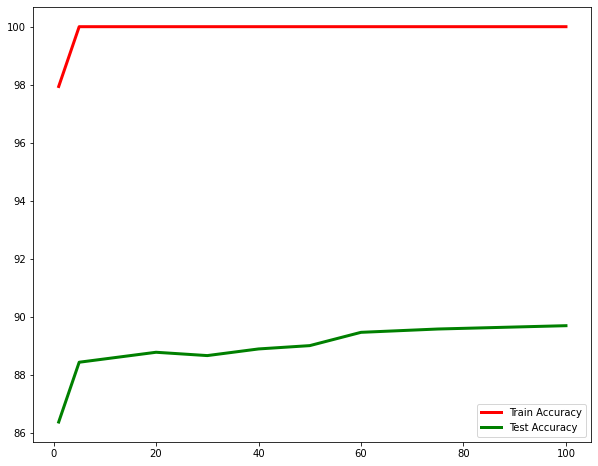

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(num_epochs_used, corona_train_accuracies2, 'r-', lw=3, label='Train Accuracy')
ax.plot(num_epochs_used, corona_test_accuracies2, 'g-', lw=3, label='Test Accuracy')
ax.legend()

plt.show()

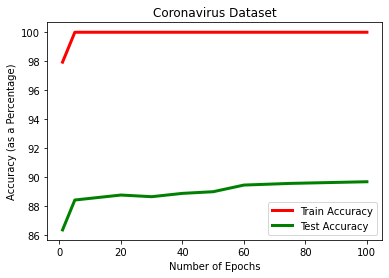

In [110]:
plt.plot(num_epochs_used, corona_train_accuracies2, 'r-', lw=3, label='Train Accuracy')
plt.plot(num_epochs_used, corona_test_accuracies2, 'g-', lw=3, label='Test Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy (as a Percentage)')
plt.title('Coronavirus Dataset')
plt.legend()

plt.show()

In [81]:
liar_test_accuracies2 = []
liar_train_accuracies2 = []

for num_epoch in num_epochs_used:
    test_accuracy, train_accuracy = trainAndTestTwoHiddenLayerModel('liar', num_epochs=num_epoch, print_epoch_mod=500)
    liar_test_accuracies2.append(test_accuracy)
    liar_train_accuracies2.append(train_accuracy)


Extracting tokens....

Extracting tokens....
Data shape for text:  (15052, 4893)
Epoch [1/1], Step [500/941], Loss: 0.4970
Test accuracy of the network: 70.37914691943128 %
Train accuracy of the network: 79.83656656922668 %

Extracting tokens....

Extracting tokens....
Data shape for text:  (15052, 4893)
Epoch [1/5], Step [500/941], Loss: 0.4970
Epoch [2/5], Step [500/941], Loss: 0.4629
Epoch [3/5], Step [500/941], Loss: 0.1473
Epoch [4/5], Step [500/941], Loss: 0.0734
Epoch [5/5], Step [500/941], Loss: 0.4773
Test accuracy of the network: 69.66824644549763 %
Train accuracy of the network: 91.26361945256444 %

Extracting tokens....

Extracting tokens....
Data shape for text:  (15052, 4893)
Epoch [1/10], Step [500/941], Loss: 0.4970
Epoch [2/10], Step [500/941], Loss: 0.4629
Epoch [3/10], Step [500/941], Loss: 0.1473
Epoch [4/10], Step [500/941], Loss: 0.0734
Epoch [5/10], Step [500/941], Loss: 0.4773
Epoch [6/10], Step [500/941], Loss: 0.0117
Epoch [7/10], Step [500/941], Loss: 0.0128

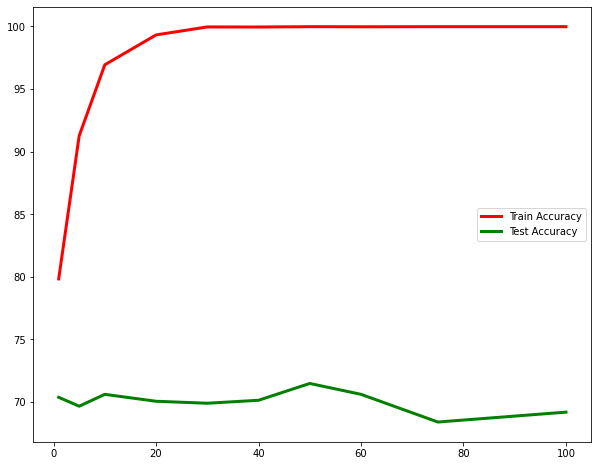

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(num_epochs_used, liar_train_accuracies2, 'r-', lw=3, label='Train Accuracy')
ax.plot(num_epochs_used, liar_test_accuracies2, 'g-', lw=3, label='Test Accuracy')
ax.legend()

plt.show()

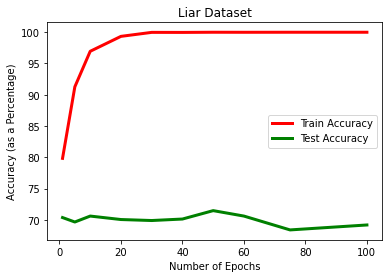

In [113]:
plt.plot(num_epochs_used, liar_train_accuracies2, 'r-', lw=3, label='Train Accuracy')
plt.plot(num_epochs_used, liar_test_accuracies2, 'g-', lw=3, label='Test Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy (as a Percentage)')
plt.title('Liar Dataset')
plt.legend()

plt.show()

In [83]:
fnn_test_accuracies2 = []
fnn_train_accuracies2 = []

for num_epoch in num_epochs_used:
    test_accuracy, train_accuracy = trainAndTestTwoHiddenLayerModel('fnn', num_epochs=num_epoch, print_epoch_mod=500)
    fnn_test_accuracies2.append(test_accuracy)
    fnn_train_accuracies2.append(train_accuracy)


Extracting tokens....

Extracting tokens....
Data shape for text:  (15212, 4975)
Epoch [1/1], Step [500/951], Loss: 0.6391
Test accuracy of the network: 79.88614800759014 %
Train accuracy of the network: 77.55719169077044 %

Extracting tokens....

Extracting tokens....
Data shape for text:  (15212, 4975)
Epoch [1/5], Step [500/951], Loss: 0.6391
Epoch [2/5], Step [500/951], Loss: 0.5884
Epoch [3/5], Step [500/951], Loss: 0.3055
Epoch [4/5], Step [500/951], Loss: 0.2669
Epoch [5/5], Step [500/951], Loss: 0.1727
Test accuracy of the network: 84.44022770398482 %
Train accuracy of the network: 83.8417039179595 %

Extracting tokens....

Extracting tokens....
Data shape for text:  (15212, 4975)
Epoch [1/10], Step [500/951], Loss: 0.6391
Epoch [2/10], Step [500/951], Loss: 0.5884
Epoch [3/10], Step [500/951], Loss: 0.3055
Epoch [4/10], Step [500/951], Loss: 0.2669
Epoch [5/10], Step [500/951], Loss: 0.1727
Epoch [6/10], Step [500/951], Loss: 0.0664
Epoch [7/10], Step [500/951], Loss: 0.1533


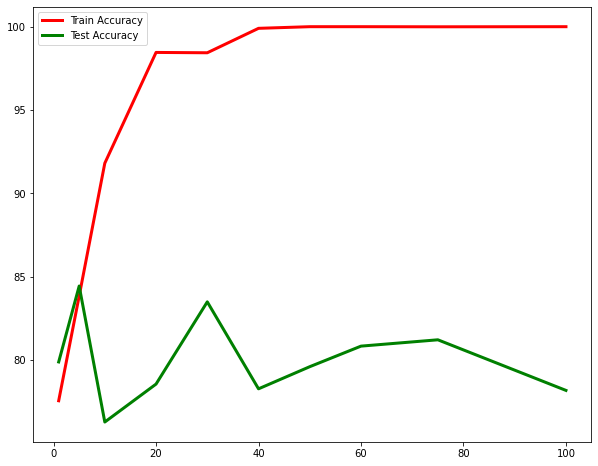

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(num_epochs_used, fnn_train_accuracies2, 'r-', lw=3, label='Train Accuracy')
ax.plot(num_epochs_used, fnn_test_accuracies2, 'g-', lw=3, label='Test Accuracy')
ax.legend()

plt.show()

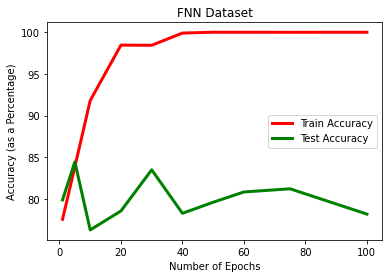

In [114]:
plt.plot(num_epochs_used, fnn_train_accuracies2, 'r-', lw=3, label='Train Accuracy')
plt.plot(num_epochs_used, fnn_test_accuracies2, 'g-', lw=3, label='Test Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy (as a Percentage)')
plt.title('FNN Dataset')
plt.legend()

plt.show()